# Temporal Causal Modeling with Graphical Granger Methods

#### Implements: Section 4.1 Synthetic Data Generation

[Paper Link](https://andrewoarnold.com/frp781-arnold.pdf)



In [561]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import permutations
import graphviz
from collections import defaultdict
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [596]:
def make_var_stationary(beta, radius=0.97):
    '''Rescale coefficients of VAR model to make stable.'''
    p = beta.shape[0]
    lag = beta.shape[1] // p
    bottom = np.hstack((np.eye(p * (lag - 1)), np.zeros((p * (lag - 1), p))))
    beta_tilde = np.vstack((beta, bottom))
    eigvals = np.linalg.eigvals(beta_tilde)
    max_eig = max(np.abs(eigvals))
    nonstationary = max_eig > radius
    if nonstationary:
        return make_var_stationary(0.95 * beta, radius)
    else:
        return beta

In [597]:
NUM_NODES     = 5
AFFINITY      = .2
MAX_LAG       = 5
T             = 1000

In [598]:
graph = np.eye(NUM_NODES, dtype=int)
# setup coefficients with random auto-correlations 
coefs = np.eye(NUM_NODES, dtype=int)*np.random.normal(0,1, size=(NUM_NODES, NUM_NODES))

In [599]:
for node in range(graph.shape[0]):
    for edge in range(graph.shape[0]):
        r = np.random.random()
        if r < AFFINITY:
            graph[node][edge] = 1
            coefs[node][edge] = np.random.normal()

In [600]:
G=nx.from_numpy_matrix(graph)

In [601]:
G.remove_edges_from(nx.selfloop_edges(G))

I'd like lagged variable to not have the same coefs.

Lagged, Geometric Functions

In [569]:
def delayed_adstock(alpha, theta, L):
        '''
    weighted average with dealyed adstock function
    
    weight_T = 
    
    returns: weights of length L to calculate weighted averages with. 
    '''
        return alpha**((np.ones(L).cumsum()-1)-theta)**2

In [570]:
alpha = .9
theta = 0
delayed_adstock(alpha, theta, MAX_LAG)

array([1.        , 0.9       , 0.6561    , 0.38742049, 0.18530202])

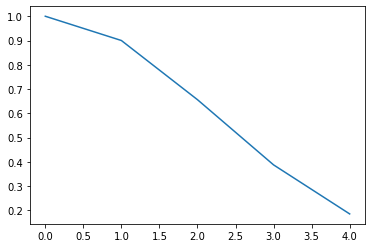

In [571]:
plt.plot(alpha**((np.ones(MAX_LAG).cumsum()-1)-theta)**2)

In [572]:
coefs_copy = np.hstack([coefs for _ in range(MAX_LAG)])

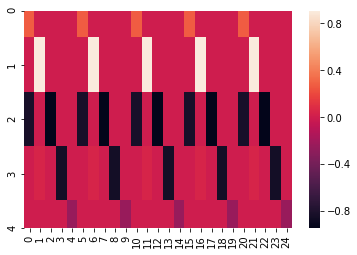

In [573]:
sns.heatmap(pd.DataFrame(coefs_copy))

In [574]:
decay = delayed_adstock(alpha, theta, MAX_LAG)
adstoc_coefs = np.hstack([coefs*decay[_] for _ in range(MAX_LAG)])

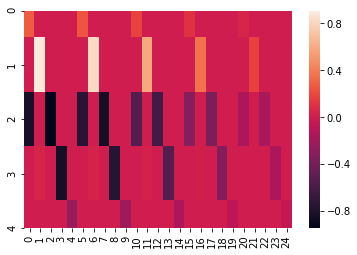

In [575]:
sns.heatmap(pd.DataFrame(adstoc_coefs))

In [587]:
#beta = make_var_stationary(coefs_copy)
beta = make_var_stationary(adstoc_coefs)


In [588]:
dot = graphviz.Digraph()
dot.graph_attr['rankdir'] = 'LR'

# nodes
for node in G.nodes:
    for t in reversed(range(MAX_LAG+1)):
        #print(t, node)
        dot.node('x%s_t%s' % (node, t), label='x%s' % node)

# AR Nodes
for node in G.nodes:
    for t in reversed(range(MAX_LAG+1)):
        if t > 0:
            dot.edge('x%s_t%s' % (node, t), 'x%s_t%s' % (node, t-1))

'''
# Temporal Nodes AR(all)
for node in G.edges:
    for t in reversed(range(MAX_LAG+1)):
        if t > 0:
            cnt = 0 
            for t_sub in list(reversed(range(t))):
                if decay[cnt] > .3:
                    dot.edge('x%s_t%s' % (node[0], t), 'x%s_t%s' % (node[1], t-cnt-1), constraint='false')
                cnt+=1

'''
# Temporal Nodes AR(1)
for node in G.edges:
    for t in reversed(range(MAX_LAG+1)):
        if t > 0:
            dot.edge('x%s_t%s' % (node[0], t), 'x%s_t%s' % (node[1], t-1), constraint='false')


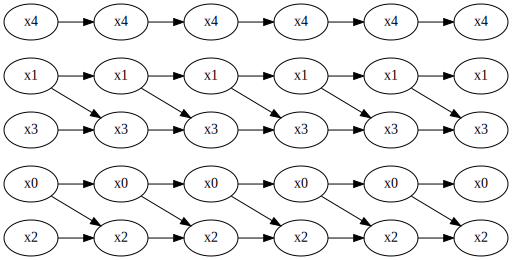

In [589]:
dot

In [590]:
# Generate data.
burn_in = 10
errors = np.random.normal(0, size=(NUM_NODES, T + burn_in))
X = np.zeros((NUM_NODES, T + burn_in))
X[:, :MAX_LAG] = errors[:, :MAX_LAG]


In [591]:
for t in range(MAX_LAG, T + burn_in):
    X[:, t] = np.dot(beta, X[:, (t-MAX_LAG):t].flatten(order='F'))
    X[:, t] += + errors[:, t-1]

In [592]:
X.T

array([[ 0.0042844 ,  0.0109087 ,  0.56552711,  0.74806188, -1.08073351],
       [ 1.38989211,  0.23123817, -0.94058718, -0.62208536,  2.70618409],
       [-0.62169684, -0.28541883,  1.22586506, -0.08407192,  0.70474156],
       ...,
       [-0.98144682, -0.68409903, -0.91504113, -1.04069826, -0.00710637],
       [ 0.40039451,  1.38034682,  1.52776817, -1.1941506 ,  0.56200349],
       [ 0.88746313,  0.31742854, -1.07256915, -1.76639564,  0.54907124]])

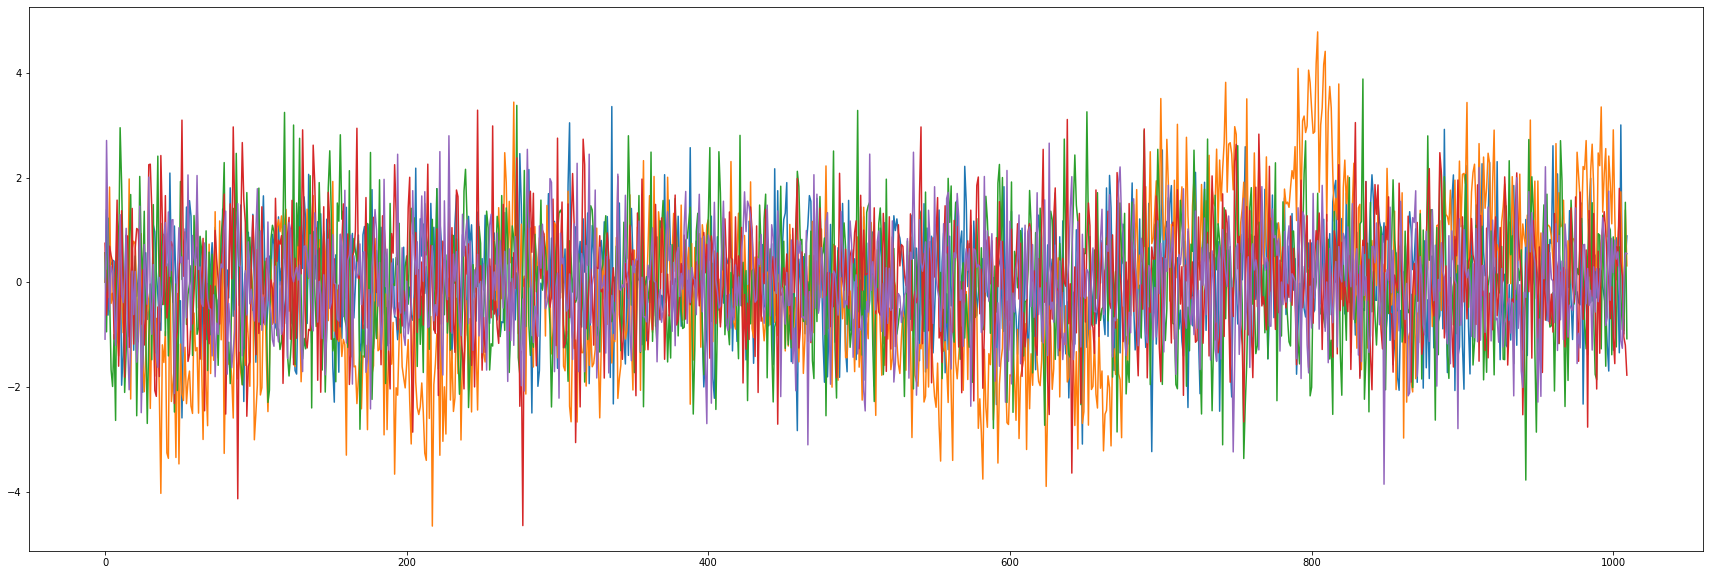

In [595]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.rcParams["figure.figsize"] = [30,10]


plt.plot(X.T)

In [608]:
output = pd.DataFrame(X.T)
output.columns = [('x%s' % i)  for i in range(X.T.shape[1])]

In [610]:
output.to_csv('output.csv', index=Fase)

In [611]:
output

,x0,x1,x2,x3,x4
0,0.004284,0.010909,0.565527,0.748062,-1.080734
1,1.389892,0.231238,-0.940587,-0.622085,2.706184
2,-0.621697,-0.285419,1.225865,-0.084072,0.704742
3,0.319996,1.818682,-0.203634,0.690878,-0.519456
4,0.334225,-0.399658,-1.663087,0.513636,0.313706
...,...,...,...,...,...
1005,3.002185,1.728153,-0.217569,0.400830,-1.114227
1006,-0.273861,0.333331,-0.898905,0.123466,-1.254280
1007,-0.981447,-0.684099,-0.915041,-1.040698,-0.007106
1008,0.400395,1.380347,1.527768,-1.194151,0.562003
